# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
from utils import get_dataset
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tf_record_path = "/app/project/waymo_data/processed/*.tfrecord"
dataset = get_dataset(tf_record_path)
dataset

INFO:tensorflow:Reading unweighted datasets: ['/app/project/waymo_data/processed/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/app/project/waymo_data/processed/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 100
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


<DatasetV1Adapter shapes: {image: (None, None, 3), source_id: (), key: (), filename: (), groundtruth_image_confidences: (None,), groundtruth_verified_neg_classes: (None,), groundtruth_not_exhaustive_classes: (None,), groundtruth_boxes: (None, 4), groundtruth_area: (None,), groundtruth_is_crowd: (None,), groundtruth_difficult: (None,), groundtruth_group_of: (None,), groundtruth_weights: (None,), groundtruth_classes: (None,), groundtruth_image_classes: (None,), original_image_spatial_shape: (2,)}, types: {image: tf.uint8, source_id: tf.string, key: tf.string, filename: tf.string, groundtruth_image_confidences: tf.float32, groundtruth_verified_neg_classes: tf.int64, groundtruth_not_exhaustive_classes: tf.int64, groundtruth_boxes: tf.float32, groundtruth_area: tf.float32, groundtruth_is_crowd: tf.bool, groundtruth_difficult: tf.int64, groundtruth_group_of: tf.bool, groundtruth_weights: tf.float32, groundtruth_classes: tf.int64, groundtruth_image_classes: tf.int64, original_image_spatial_sh

## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [3]:
def display_instances(batch):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """
    # color for different classes
    colormap = {1: [1, 0 , 0], 2: [0, 0, 1], 4: [0, 1, 0]}
    
    size = len(batch)
    cols = min(5, size)
    rows = (size+cols-1)//cols
    f, ax = plt.subplots(rows, cols, figsize=(20, 10))
    for i, data in enumerate(batch):
        x = i % rows
        y = i % cols
        
        img = data['image']
        ax[x, y].imshow(img)
    
        for cl, bb in zip(data['groundtruth_classes'], data['groundtruth_boxes']):
            y1, x1, y2, x2 = bb
            y1 *= img.shape[0]
            x1 *= img.shape[1]
            y2 *= img.shape[0]
            x2 *= img.shape[1]
            rec = Rectangle((x1, y1), x2 - x1, y2 - y1, facecolor='none',
                           edgecolor=colormap[cl])
            ax[x, y].add_patch(rec)
            ax[x, y].axis('off')
        
    plt.tight_layout()
    plt.show()

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

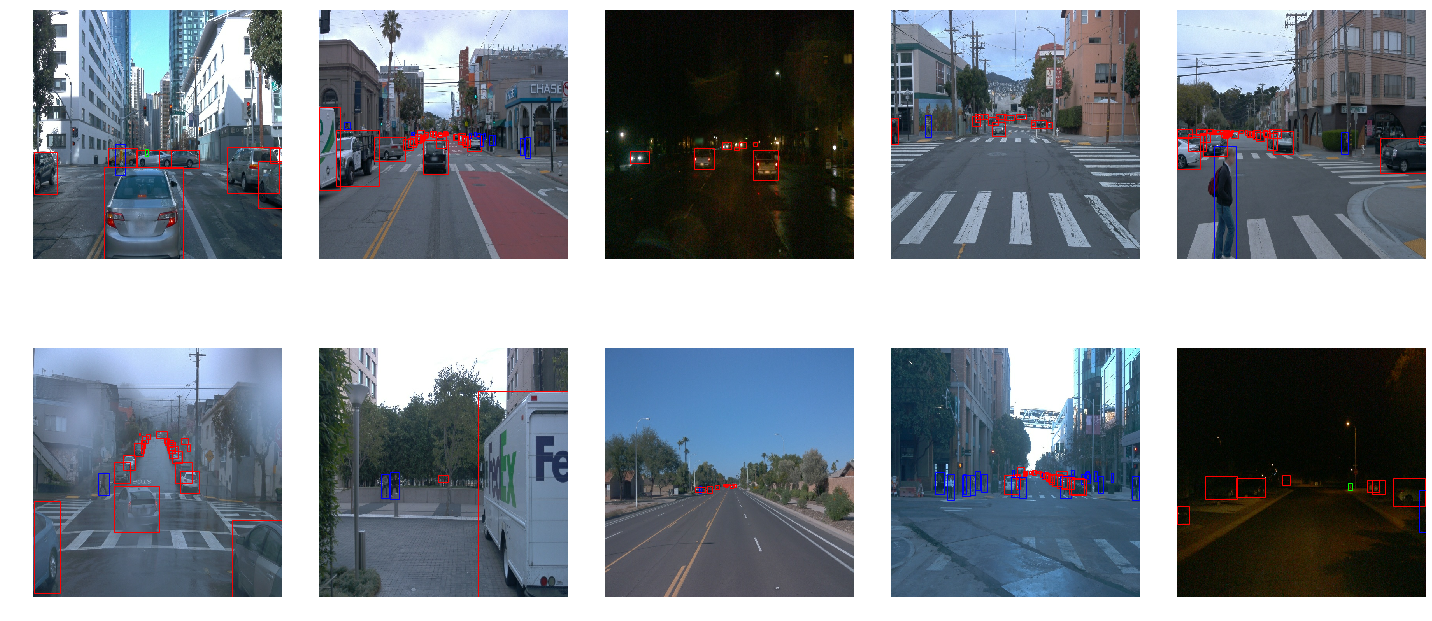

In [4]:
## STUDENT SOLUTION HERE
batch = dataset.shuffle(10).take(10)
display_instances(list(batch.as_numpy_iterator()))

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

In [24]:
from PIL import Image, ImageStat

# 1. get an idea about the distribution of the detected object counts in each image
# 2. get an idea about the distribution of the image brightness
    
def brightness(im_array):
   im = Image.fromarray(im_array).convert('L')
   stat = ImageStat.Stat(im)
   return stat.rms[0]

# [vehicle count, pedastrian count, cyclist count, total object count]
obj_counts = [[] for _ in range (4)]
brightness_list = []

subset = list(dataset.take(100).as_numpy_iterator())

# collect the needed data
for data in subset:
    obj_count = [0] * 4
    
    for cl in data['groundtruth_classes']:
        if cl == 1:
            obj_count[0] += 1
        elif cl == 2:
            obj_count[1] += 1
        elif cl == 4:
            obj_count[2] += 1
    obj_count[3] = sum(obj_count[:3])
    for i in range(4):
        obj_counts[i].append(obj_count[i])
    
    cur_brightness = brightness(data['image']);
    brightness_list.append(cur_brightness)


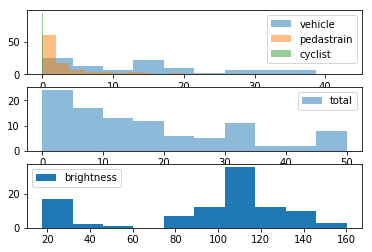

In [25]:
# visuallize the distribution result
fig, axs = plt.subplots(3)

axs[0].hist(obj_counts[0], alpha=0.5, label='vehicle')
axs[0].hist(obj_counts[1], alpha=0.5, label='pedastrain')
axs[0].hist(obj_counts[2], alpha=0.5, label='cyclist')
axs[0].legend(loc='upper right')

axs[1].hist(obj_counts[3], alpha=0.5, label='total')
axs[1].legend(loc='upper right')

# visualize the brightness distribution
axs[2].hist(list(brightness_list), label='brightness')
axs[2].legend(loc='upper left')

plt.show()